In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_excel("mydata.xlsx", sheet_name="Sheet1")
df.head()
# Display summary statistics
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
           Age Sold  Size(sqft)  Lot size(sqrt)    Prop tax         HOA  \
count  6.000000e+02  600.000000      600.000000  600.000000  600.000000   
mean   2.960595e-17    0.183560        0.054661    0.088010    0.015072   
std    1.000834e+00    0.096647        0.044146    0.071307    0.049135   
min   -1.739637e+00    0.000000        0.000000    0.000000    0.000000   
25%   -8.211257e-01    0.121425        0.034973    0.044431    0.000000   
50%    1.150495e-01    0.160876        0.046953    0.073297    0.000000   
75%    8.039331e-01    0.219017        0.063673    0.107751    0.008775   
max    2.464319e+00    1.000000        0.693147    0.693147    0.693147   

       Med Income  % CollegeUp     Med Age  Commute Time      Floors  ...  \
count  600.000000   600.000000  600.000000  6.000000e+02  600.000000  ...   
mean     0.392174    14.448400   34.800000 -9.207450e-16    1.123333  ...   
std      0.222898    18.630188    2.548495  1.000834e+00    0.329094  ..

Highly Correlated Feature Pairs (Threshold > 0.8):
('Med Income', 'Majority race')
('Med Income', 'Crime Rate')
('% CollegeUp', 'Party In Senate')
('Year to election', 'Party in House')
('Year to election', 'Party In Senate')
('Party in House', 'Party In Senate')


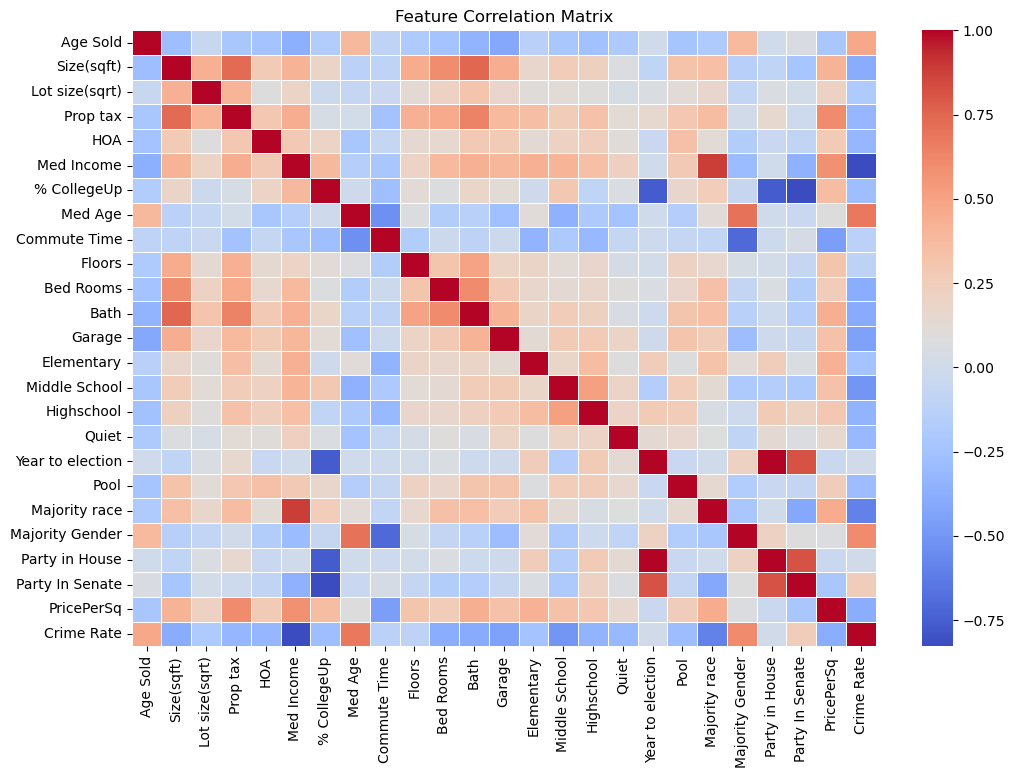

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = df.corr()

# Set threshold for high correlation
threshold = 0.8

# Find highly correlated features (absolute correlation > threshold)
high_corr_pairs = np.where(np.abs(corr_matrix) > threshold)
high_corr_pairs = [(corr_matrix.index[i], corr_matrix.columns[j]) 
                   for i, j in zip(*high_corr_pairs) if i != j and i < j]

# Print highly correlated feature pairs
print("Highly Correlated Feature Pairs (Threshold > 0.8):")
for pair in high_corr_pairs:
    print(pair)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

Training set: 480 samples
Testing set: 120 samples


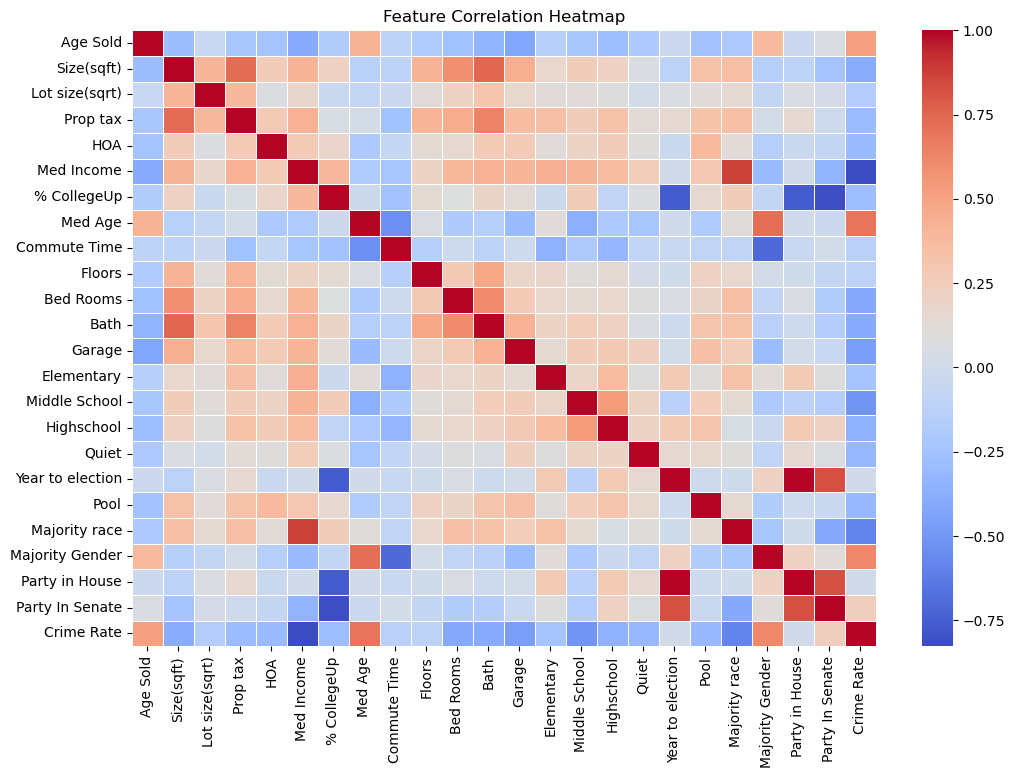

In [9]:
from sklearn.model_selection import train_test_split

# Define the target variable (PricePerSq)
target = 'PricePerSq'

# Define feature set (excluding target variable)
X = df.drop(columns=[target])
y = df[target]

# Split into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting datasets
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(X_train.corr(), annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


In [27]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, ElasticNet
import numpy as np
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Define 10-Fold Cross-Validation
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize Ridge and Elastic Net models
ridge = Ridge()
elastic_net = ElasticNet()

# Evaluate Ridge using 10-Fold CV (Outer Loop)
ridge_scores = cross_val_score(ridge, X_train_scaled, y_train, cv=outer_cv, scoring='neg_mean_squared_error')
ridge_rmse = np.sqrt(-ridge_scores.mean())

# Evaluate Elastic Net using 10-Fold CV (Outer Loop)
elastic_scores = cross_val_score(elastic_net, X_train_scaled, y_train, cv=outer_cv, scoring='neg_mean_squared_error')
elastic_rmse = np.sqrt(-elastic_scores.mean())




# Display results
print(f"Initial Ridge Regression RMSE (Outer CV): {ridge_rmse:.4f}")
print(f"Initial Elastic Net RMSE (Outer CV): {elastic_rmse:.4f}")

Initial Ridge Regression RMSE (Outer CV): 56.0802
Initial Elastic Net RMSE (Outer CV): 56.6794


In [59]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
import numpy as np

# Define a range of alpha values
alphas = np.logspace(-4, 4, 100)

# Fit RidgeCV to find the best alpha
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train_scaled, y_train)  # Ensure scaled data is used

# Extract best alpha for Ridge
best_ridge_alpha = ridge_cv.alpha_
print(f"Best Alpha for Ridge: {best_ridge_alpha}")

# Define hyperparameter grid for Elastic Net
param_grid = {
    "alpha": np.logspace(-2, 2, 20),  # Increase alpha range
    "l1_ratio": np.linspace(0.1, 0.9, 9)  # Avoid extreme 0 or 1 values
}

# Perform GridSearchCV for Elastic Net
elastic_cv = GridSearchCV(
    ElasticNet(max_iter=5000),  # Increase iterations
    param_grid, 
    cv=10, 
    scoring='neg_mean_squared_error'
)

elastic_cv.fit(X_train_scaled, y_train)  # **Must fit before accessing best_params_**

# Extract best hyperparameters after fitting
best_elastic_alpha = elastic_cv.best_params_['alpha']
best_elastic_l1_ratio = elastic_cv.best_params_['l1_ratio']

print(f"Best Alpha for Elastic Net: {best_elastic_alpha}")
print(f"Best L1 Ratio for Elastic Net: {best_elastic_l1_ratio}")


Best Alpha for Ridge: 31.257158496882415
Best Alpha for Elastic Net: 0.7847599703514611
Best L1 Ratio for Elastic Net: 0.9


In [66]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
# Train Ridge Model using best alpha
ridge_final = Ridge(alpha=best_ridge_alpha)
ridge_final.fit(X_train, y_train)

# Train Elastic Net Model using best alpha and l1_ratio
elastic_final = ElasticNet(alpha=best_elastic_alpha, l1_ratio=best_elastic_l1_ratio, max_iter=10000, tol=0.001)
elastic_final.fit(X_train, y_train)

# Predict on Test Data
ridge_pred = ridge_final.predict(X_test)
elastic_pred = elastic_final.predict(X_test)

# Evaluate Performance for Ridge
ridge_mse = mean_squared_error(y_test, ridge_pred)
ridge_rmse = np.sqrt(ridge_mse)
ridge_r2 = r2_score(y_test, ridge_pred)

# Calculate Adjusted R² for Ridge
n = len(y_test)  # Number of test samples
p = X_train.shape[1]  # Number of predictors
ridge_adj_r2 = 1 - (1 - ridge_r2) * (n - 1) / (n - p - 1)

# Evaluate Performance for Elastic Net
elastic_mse = mean_squared_error(y_test, elastic_pred)
elastic_rmse = np.sqrt(elastic_mse)
elastic_r2 = r2_score(y_test, elastic_pred)

# Calculate Adjusted R² for Elastic Net
elastic_adj_r2 = 1 - (1 - elastic_r2) * (n - 1) / (n - p - 1)

# Display Results
print(f"Final Ridge Regression Performance on Test Data:")
print(f" - MSE: {ridge_mse:.4f}")
print(f" - RMSE: {ridge_rmse:.4f}")
print(f" - R² Score: {ridge_r2:.4f}")
print(f" - Adjusted R²: {ridge_adj_r2:.4f}")

print("\nFinal Elastic Net Performance on Test Data:")
print(f" - MSE: {elastic_mse:.4f}")
print(f" - RMSE: {elastic_rmse:.4f}")
print(f" - R² Score: {elastic_r2:.4f}")
print(f" - Adjusted R²: {elastic_adj_r2:.4f}")

Final Ridge Regression Performance on Test Data:
 - MSE: 2365.0395
 - RMSE: 48.6317
 - R² Score: 0.5117
 - Adjusted R²: 0.3884

Final Elastic Net Performance on Test Data:
 - MSE: 2377.3714
 - RMSE: 48.7583
 - R² Score: 0.5092
 - Adjusted R²: 0.3852


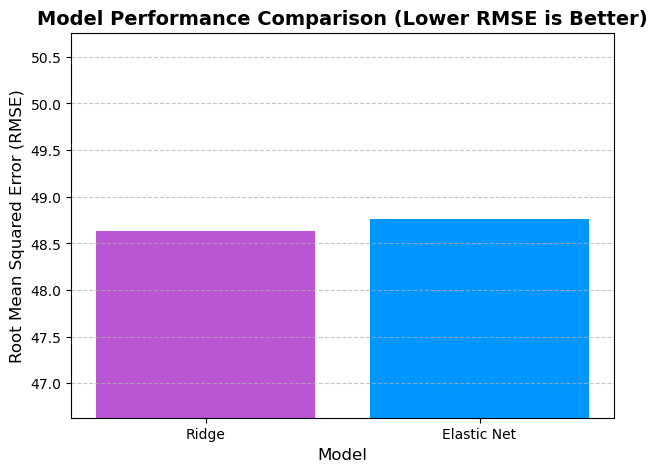

In [68]:
import matplotlib.pyplot as plt

# Define new colors
colors = ["#BA55D3", "#0096FF"]  # Warm Purple for Ridge, Electric Blue for Elastic Net

# Bar chart comparing RMSE of Ridge vs. Elastic Net
plt.figure(figsize=(7,5))
plt.bar(["Ridge", "Elastic Net"], [ridge_rmse, elastic_rmse], color=colors)

# Labels and formatting
plt.ylabel("Root Mean Squared Error (RMSE)", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.title("Model Performance Comparison (Lower RMSE is Better)", fontsize=14, fontweight='bold')

# Adjust y-axis limits for better visualization
plt.ylim(min(ridge_rmse, elastic_rmse) - 2, max(ridge_rmse, elastic_rmse) + 2)

# Add grid lines for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

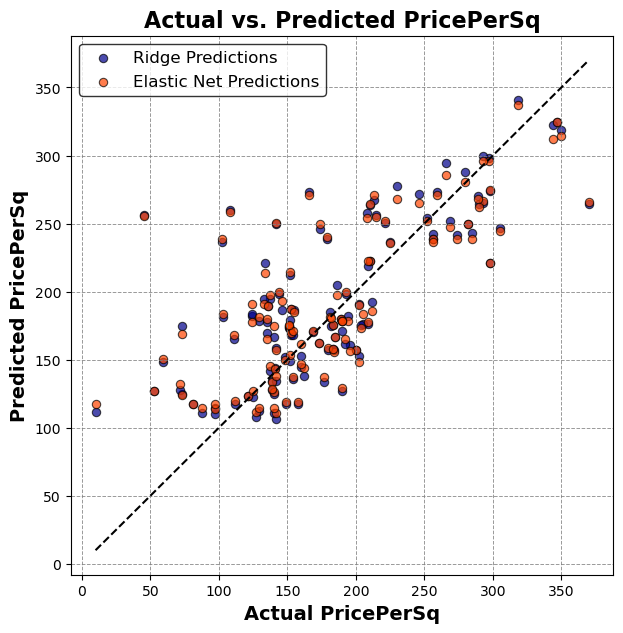

In [70]:
import matplotlib.pyplot as plt

# Define Dark Blue and Bright Orange colors
ridge_color = (0/255, 0/255, 139/255)  # Dark Blue (Normalized RGB)
elastic_color = (255/255, 69/255, 0/255)  # Bright Orange (Normalized RGB)

plt.figure(figsize=(7,7))

# Ridge predictions (Dark Blue)
plt.scatter(y_test, ridge_pred, alpha=0.7, label="Ridge Predictions", color=ridge_color, edgecolors='k', linewidth=0.8)

# Elastic Net predictions (Bright Orange)
plt.scatter(y_test, elastic_pred, alpha=0.7, label="Elastic Net Predictions", color=elastic_color, edgecolors='k', linewidth=0.8)

# Perfect prediction line (diagonal)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='black', linewidth=1.5)

# Labels and formatting
plt.xlabel("Actual PricePerSq", fontsize=14, fontweight='bold', color='black')
plt.ylabel("Predicted PricePerSq", fontsize=14, fontweight='bold', color='black')
plt.title("Actual vs. Predicted PricePerSq", fontsize=16, fontweight='bold', color='black')

# Customize grid
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.8, color='gray')

# Legend styling
plt.legend(fontsize=12, loc="best", edgecolor='black')

# Show plot
plt.show()

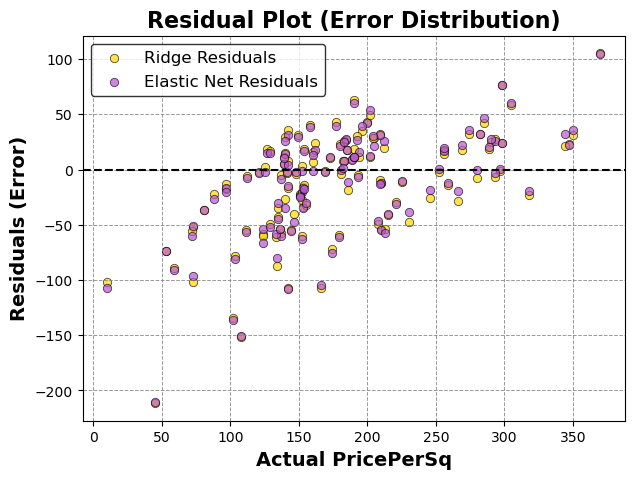

In [72]:
import matplotlib.pyplot as plt

# Define new colors
ridge_color = "#FFD700"  # Golden Yellow (bright and highly visible)
elastic_color = "#BA55D3"  # Warm Purple (Medium Orchid)

ridge_residuals = y_test - ridge_pred
elastic_residuals = y_test - elastic_pred

plt.figure(figsize=(7,5))

# Ridge Residuals (Golden Yellow)
plt.scatter(y_test, ridge_residuals, alpha=0.7, label="Ridge Residuals", 
            color=ridge_color, edgecolors='k', linewidth=0.6)

# Elastic Net Residuals (Warm Purple)
plt.scatter(y_test, elastic_residuals, alpha=0.7, label="Elastic Net Residuals", 
            color=elastic_color, edgecolors='k', linewidth=0.6)

# Zero-error reference line
plt.axhline(0, color='black', linestyle='--', linewidth=1.5)

# Labels and formatting
plt.xlabel("Actual PricePerSq", fontsize=14, fontweight='bold', color='black')
plt.ylabel("Residuals (Error)", fontsize=14, fontweight='bold', color='black')
plt.title("Residual Plot (Error Distribution)", fontsize=16, fontweight='bold', color='black')

# Customize grid
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.8, color='gray')

# Legend styling
plt.legend(fontsize=12, loc="best", edgecolor='black')

# Show plot
plt.show()

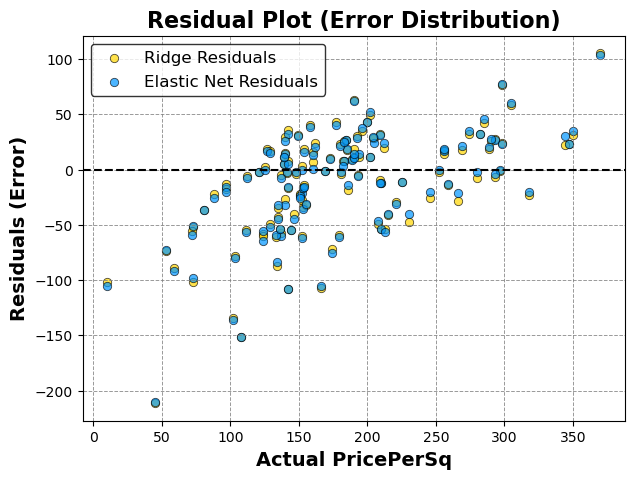

In [53]:
import matplotlib.pyplot as plt

# Define high-contrast colors
ridge_color = "#FFD700"  # Bright Yellow
elastic_color = "#0096FF"  # Electric Blue

ridge_residuals = y_test - ridge_pred
elastic_residuals = y_test - elastic_pred

plt.figure(figsize=(7,5))

# Ridge Residuals (Bright Yellow)
plt.scatter(y_test, ridge_residuals, alpha=0.7, label="Ridge Residuals", 
            color=ridge_color, edgecolors='k', linewidth=0.6)

# Elastic Net Residuals (Electric Blue)
plt.scatter(y_test, elastic_residuals, alpha=0.7, label="Elastic Net Residuals", 
            color=elastic_color, edgecolors='k', linewidth=0.6)

# Zero-error reference line
plt.axhline(0, color='black', linestyle='--', linewidth=1.5)

# Labels and formatting
plt.xlabel("Actual PricePerSq", fontsize=14, fontweight='bold', color='black')
plt.ylabel("Residuals (Error)", fontsize=14, fontweight='bold', color='black')
plt.title("Residual Plot (Error Distribution)", fontsize=16, fontweight='bold', color='black')

# Customize grid
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.8, color='gray')

# Legend styling
plt.legend(fontsize=12, loc="best", edgecolor='black')

# Show plot
plt.show()

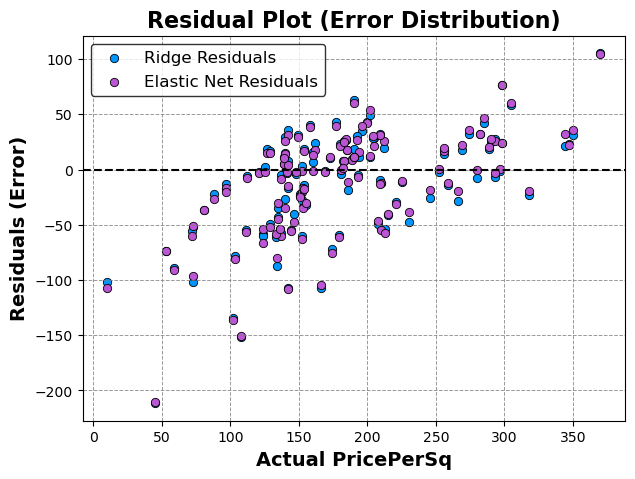

In [74]:
import matplotlib.pyplot as plt

# Define new colors
ridge_color = "#0096FF"  # Electric Blue (Bright & high contrast)
elastic_color = "#BA55D3"  # Warm Purple (Medium Orchid)

ridge_residuals = y_test - ridge_pred
elastic_residuals = y_test - elastic_pred

plt.figure(figsize=(7,5))

# Ridge Residuals (Electric Blue)
plt.scatter(y_test, ridge_residuals, alpha=1, label="Ridge Residuals", 
            color=ridge_color, edgecolors='k', linewidth=0.6)

# Elastic Net Residuals (Warm Purple)
plt.scatter(y_test, elastic_residuals, alpha=1, label="Elastic Net Residuals", 
            color=elastic_color, edgecolors='k', linewidth=0.6)

# Zero-error reference line
plt.axhline(0, color='black', linestyle='--', linewidth=1.5)

# Labels and formatting
plt.xlabel("Actual PricePerSq", fontsize=14, fontweight='bold', color='black')
plt.ylabel("Residuals (Error)", fontsize=14, fontweight='bold', color='black')
plt.title("Residual Plot (Error Distribution)", fontsize=16, fontweight='bold', color='black')

# Customize grid
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.8, color='gray')

# Legend styling
plt.legend(fontsize=12, loc="best", edgecolor='black')

# Show plot
plt.show()

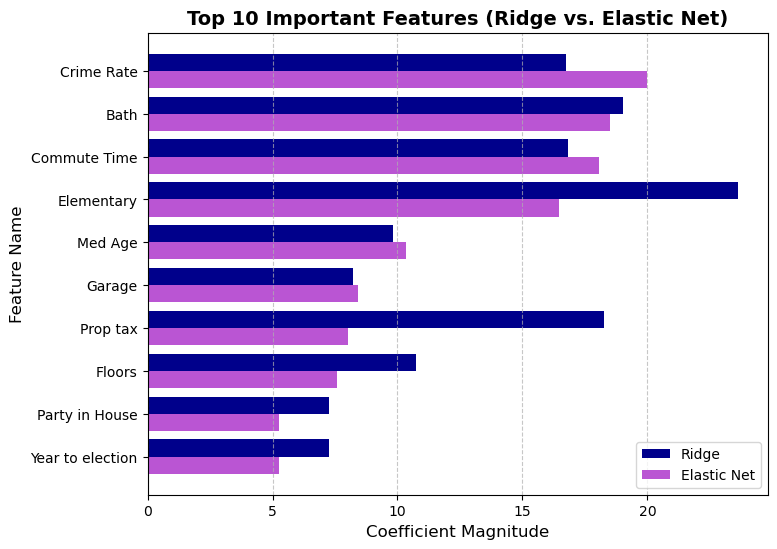

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance (coefficients) for Elastic Net
elastic_importance = pd.Series(elastic_final.coef_, index=X_train.columns).abs().sort_values(ascending=False)

# Get feature importance (coefficients) for Ridge
ridge_importance = pd.Series(ridge_final.coef_, index=X_train.columns).abs().sort_values(ascending=False)

# Select top 10 features based on Elastic Net importance
top_features = elastic_importance[:10].index  # Most important to least important

# Retrieve corresponding Ridge importance for the same features
ridge_top = ridge_importance[top_features]
elastic_top = elastic_importance[top_features]

# Create a grouped bar chart (top to bottom layout)
plt.figure(figsize=(8,6))
x = np.arange(len(top_features))  # X-axis positions

plt.barh(x - 0.2, ridge_top, height=0.4, label="Ridge", color="#00008B")  # Dark Blue
plt.barh(x + 0.2, elastic_top, height=0.4, label="Elastic Net", color="#BA55D3")  # Warm Purple (Medium Orchid)

# Set labels and formatting
plt.yticks(x, top_features)
plt.xlabel("Coefficient Magnitude", fontsize=12)
plt.ylabel("Feature Name", fontsize=12)
plt.title("Top 10 Important Features (Ridge vs. Elastic Net)", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Flip the Y-axis so the most important features appear at the top
plt.gca().invert_yaxis()

# Show plot
plt.show()

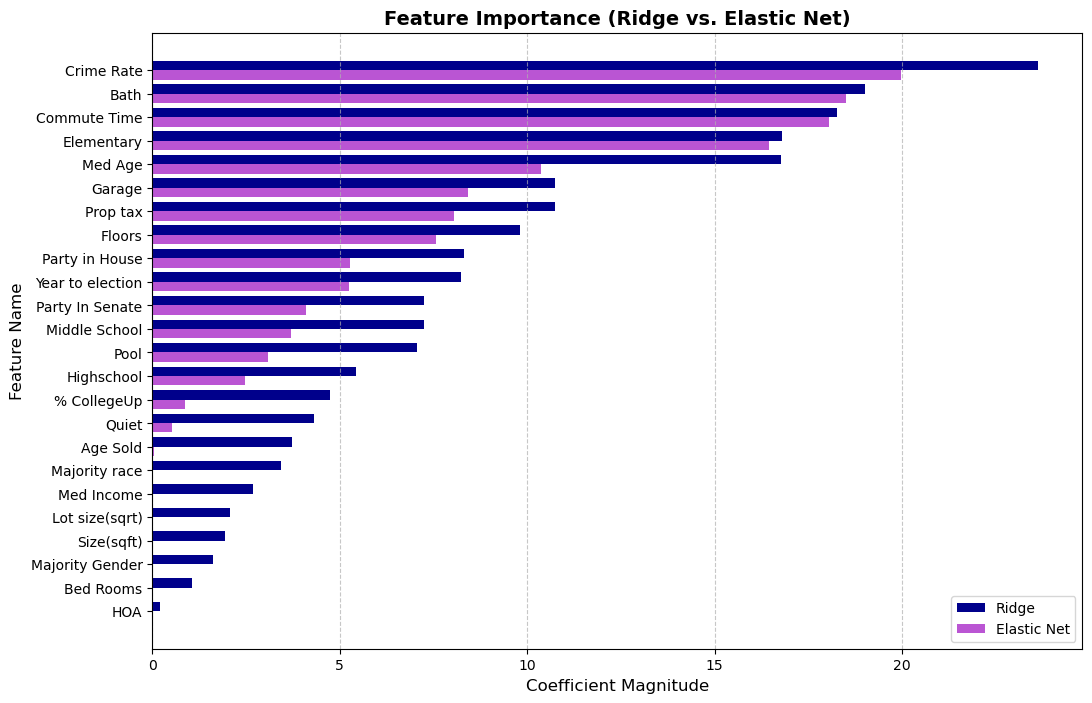

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance (coefficients) for Elastic Net
elastic_importance = pd.Series(elastic_final.coef_, index=X_train.columns).abs().sort_values(ascending=False)

# Get feature importance (coefficients) for Ridge
ridge_importance = pd.Series(ridge_final.coef_, index=X_train.columns).abs().sort_values(ascending=False)

# Create a grouped bar chart (top to bottom layout)
plt.figure(figsize=(12,8))
x = np.arange(len(elastic_importance))  # X-axis positions for all features

plt.barh(x - 0.2, ridge_importance, height=0.4, label="Ridge", color="#00008B")  # Dark Blue
plt.barh(x + 0.2, elastic_importance, height=0.4, label="Elastic Net", color="#BA55D3")  # Warm Purple (Medium Orchid)

# Set labels and formatting
plt.yticks(x, elastic_importance.index)  # Display all feature names on the y-axis
plt.xlabel("Coefficient Magnitude", fontsize=12)
plt.ylabel("Feature Name", fontsize=12)
plt.title("Feature Importance (Ridge vs. Elastic Net)", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Flip the Y-axis so the most important features appear at the top
plt.gca().invert_yaxis()

# Show plot
plt.show()

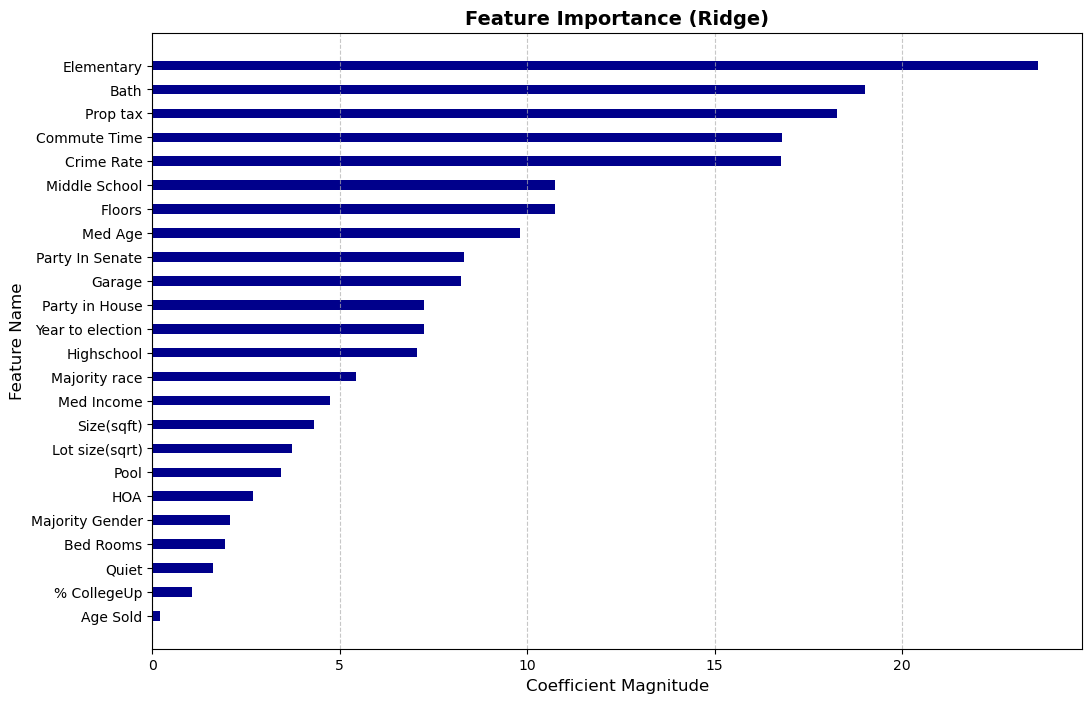

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance (coefficients) for Ridge
ridge_importance = pd.Series(ridge_final.coef_, index=X_train.columns).abs().sort_values(ascending=False)

# Create a bar chart for Ridge feature importance
plt.figure(figsize=(12,8))
x = np.arange(len(ridge_importance))  # X-axis positions for all features

plt.barh(x, ridge_importance, height=0.4, label="Ridge", color="#00008B")  # Dark Blue

# Set labels and formatting
plt.yticks(x, ridge_importance.index)  # Display all feature names on the y-axis
plt.xlabel("Coefficient Magnitude", fontsize=12)
plt.ylabel("Feature Name", fontsize=12)
plt.title("Feature Importance (Ridge)", fontsize=14, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Flip the Y-axis so the most important features appear at the top
plt.gca().invert_yaxis()

# Show plot
plt.show()

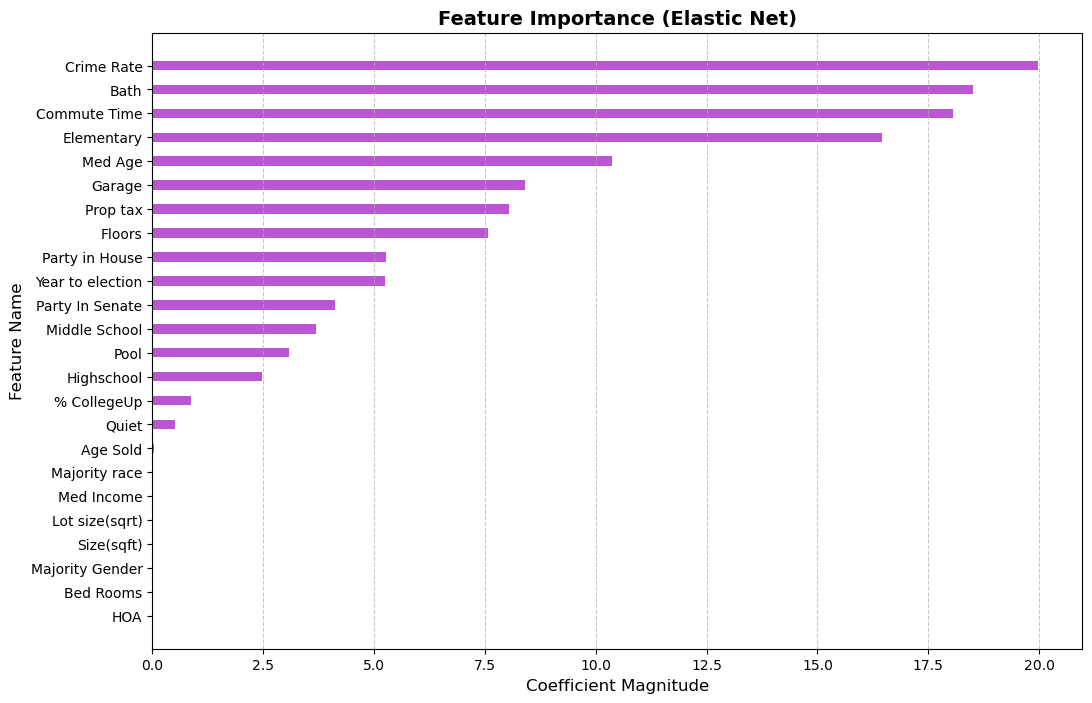

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance (coefficients) for Elastic Net
elastic_importance = pd.Series(elastic_final.coef_, index=X_train.columns).abs().sort_values(ascending=False)

# Create a bar chart for Elastic Net feature importance
plt.figure(figsize=(12,8))
x = np.arange(len(elastic_importance))  # X-axis positions for all features

plt.barh(x, elastic_importance, height=0.4, label="Elastic Net", color="#BA55D3")  # Warm Purple (Medium Orchid)

# Set labels and formatting
plt.yticks(x, elastic_importance.index)  # Display all feature names on the y-axis
plt.xlabel("Coefficient Magnitude", fontsize=12)
plt.ylabel("Feature Name", fontsize=12)
plt.title("Feature Importance (Elastic Net)", fontsize=14, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Flip the Y-axis so the most important features appear at the top
plt.gca().invert_yaxis()

# Show plot
plt.show()

In [86]:
# Expanded k range for better generalization
knn_param_grid = {'n_neighbors': [5, 7, 10, 15, 20, 30, 50, 70]}  # More stable values

# Use uniform weights instead of distance-based (reduce sensitivity to noise)
knn_grid = GridSearchCV(
    KNeighborsRegressor(weights='uniform', metric='euclidean'),  # Changed to uniform weighting
    knn_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Perform Nested Cross-Validation (Outer 10-Fold CV)
nested_scores = cross_val_score(knn_grid, X_train_scaled, y_train, cv=outer_cv, 
                                scoring='neg_mean_squared_error', n_jobs=-1)

# Convert negative MSE to RMSE
nested_rmse = np.sqrt(-nested_scores)

# Print results
print(f"Improved Nested CV RMSE Scores: {nested_rmse}")
print(f"Mean RMSE: {nested_rmse.mean():.4f}")
print(f"Standard Deviation of RMSE: {nested_rmse.std():.4f}")

# Train Final Model on Full Training Data
knn_grid.fit(X_train_scaled, y_train)

# Get Best k
best_k = knn_grid.best_params_['n_neighbors']
print(f"New Best k Value: {best_k}")

# Evaluate on Test Data
y_pred = knn_grid.best_estimator_.predict(X_test_scaled)

# Compute Metrics
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_pred)

# Print Final Model Performance
print(f"Final Model Test MSE: {test_mse:.4f}")
print(f"Final Model Test RMSE: {test_rmse:.4f}")
print(f"Final Model Test R²: {test_r2:.4f}")


Improved Nested CV RMSE Scores: [57.67584764 55.81918312 72.42288747 55.20227954 41.95152295 51.11741477
 52.11401963 45.15226093 85.41462386 59.02146855]
Mean RMSE: 57.5892
Standard Deviation of RMSE: 12.1501
New Best k Value: 15
Final Model Test MSE: 1978.9374
Final Model Test RMSE: 44.4852
Final Model Test R²: 0.5914


In [92]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define refined hyperparameter grid
param_dist = {
    'n_estimators': [50, 100, 200, 500],  # Include 50 for faster training
    'max_depth': [10, 20, 30],  # Remove extreme 50 depth
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize Random Forest model
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Use RandomizedSearchCV for efficiency (instead of full GridSearchCV)
random_search = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_dist, 
    n_iter=20,  # Try 20 random combinations instead of all
    cv=5, 
    scoring='r2',  # Optimize based on R²
    n_jobs=-1, 
    verbose=1,
    random_state=42
)

# Perform hyperparameter tuning on the training set
random_search.fit(X_train_scaled, y_train)  # Scaling is fine but not needed for RF

# Get the best model
best_rf = random_search.best_estimator_
print("Best hyperparameters:", random_search.best_params_)

# Train the best model on the full training set
best_rf.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = best_rf.predict(X_test_scaled)

# Compute Evaluation Metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Test Set R² Score: {r2:.4f}")
print(f"Test Set MSE: {mse:.4f}")
print(f"Test Set RMSE: {rmse:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}
Test Set R² Score: 0.6101
Test Set MSE: 1888.4794
Test Set RMSE: 43.4566


In [94]:
!pip install xgboost

In [104]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Define hyperparameter grid for XGBoost
param_grid = {
    'n_estimators': [200, 500, 1000],   # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1], # Learning rate
    'max_depth': [3, 6, 10],            # Tree depth
    'min_child_weight': [1, 3, 5],      # Minimum sum of instance weights in a child node
    'subsample': [0.8, 1.0],            # Fraction of data used per boosting round
    'colsample_bytree': [0.8, 1.0]      # Fraction of features per boosting round
}

# Initialize XGBoost Regressor
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

# Perform Grid Search with 5-fold CV
grid_search_xgb = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='r2',  # Optimize for R²
    n_jobs=-1,
    verbose=1
)

# Fit the model on the training data
grid_search_xgb.fit(X_train, y_train)

# Get the best model
best_xgb = grid_search_xgb.best_estimator_
print("Best hyperparameters for XGBoost:", grid_search_xgb.best_params_)
print(f"Best CV R² Score: {grid_search_xgb.best_score_:.4f}")

# Predict on the test set
y_pred_xgb = best_xgb.predict(X_test)

# Compute Evaluation Metrics
r2_xgb = r2_score(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

print(f"XGBoost Test Set R² Score: {r2_xgb:.4f}")
print(f"XGBoost Test Set MSE: {mse_xgb:.4f}")
print(f"XGBoost Test Set RMSE: {rmse_xgb:.4f}")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best hyperparameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}
Best CV R² Score: 0.5787
XGBoost Test Set R² Score: 0.5648
XGBoost Test Set MSE: 2107.7355
XGBoost Test Set RMSE: 45.9101


Default XGBoost R²: 0.5190, MSE: 2329.8062, RMSE: 48.2681
Optimized XGBoost R²: 0.5648, MSE: 2107.7355, RMSE: 45.9101


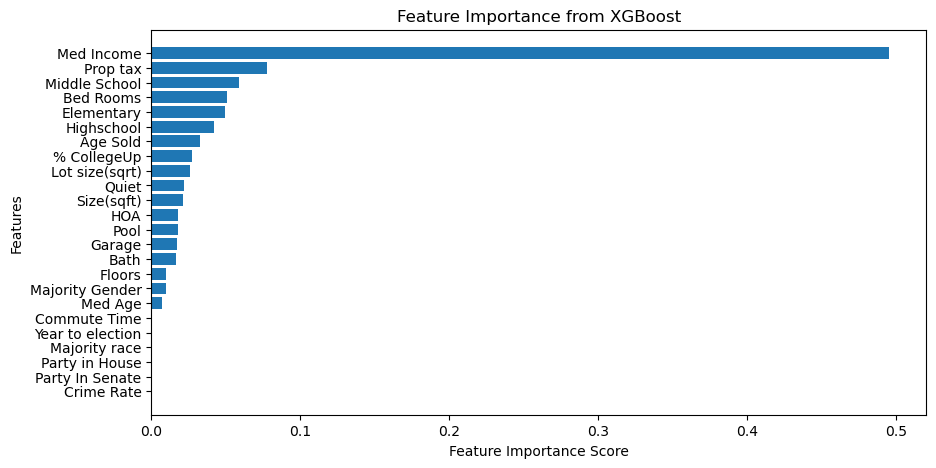

Reduced Feature XGBoost R²: 0.5656, MSE: 2104.2912, RMSE: 45.8726


In [108]:
###TRY to improve XGBoost -> Quicker but not as good as RF
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Train XGBoost with Default Hyperparameters
default_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
default_xgb.fit(X_train, y_train)
y_pred_default = default_xgb.predict(X_test)

r2_default = r2_score(y_test, y_pred_default)
mse_default = mean_squared_error(y_test, y_pred_default)
rmse_default = np.sqrt(mse_default)

print(f"Default XGBoost R²: {r2_default:.4f}, MSE: {mse_default:.4f}, RMSE: {rmse_default:.4f}")

# Train XGBoost with Best Hyperparameters from GridSearchCV
best_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    colsample_bytree=1.0,
    learning_rate=0.01,
    max_depth=6,
    min_child_weight=5,
    n_estimators=200,
    subsample=0.8
)

best_xgb.fit(X_train, y_train)
y_pred_best = best_xgb.predict(X_test)

r2_best = r2_score(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)

print(f"Optimized XGBoost R²: {r2_best:.4f}, MSE: {mse_best:.4f}, RMSE: {rmse_best:.4f}")

# Feature Importance Analysis
feature_importances = best_xgb.feature_importances_
feature_names = X_train.columns
importance_df = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh([x[0] for x in importance_df], [x[1] for x in importance_df])
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance from XGBoost")
plt.gca().invert_yaxis()
plt.show()

# Drop low-importance features (features with near-zero importance)
important_features = [f for f, imp in importance_df if imp > 0.01]  # Adjust threshold as needed
X_train_reduced = X_train[important_features]
X_test_reduced = X_test[important_features]

# Retrain XGBoost on Important Features
best_xgb.fit(X_train_reduced, y_train)
y_pred_reduced = best_xgb.predict(X_test_reduced)

r2_reduced = r2_score(y_test, y_pred_reduced)
mse_reduced = mean_squared_error(y_test, y_pred_reduced)
rmse_reduced = np.sqrt(mse_reduced)

print(f"Reduced Feature XGBoost R²: {r2_reduced:.4f}, MSE: {mse_reduced:.4f}, RMSE: {rmse_reduced:.4f}")


Default XGBoost R²: 0.5190, MSE: 2329.8062, RMSE: 48.2681
Optimized XGBoost R²: 0.5648, MSE: 2107.7355, RMSE: 45.9101


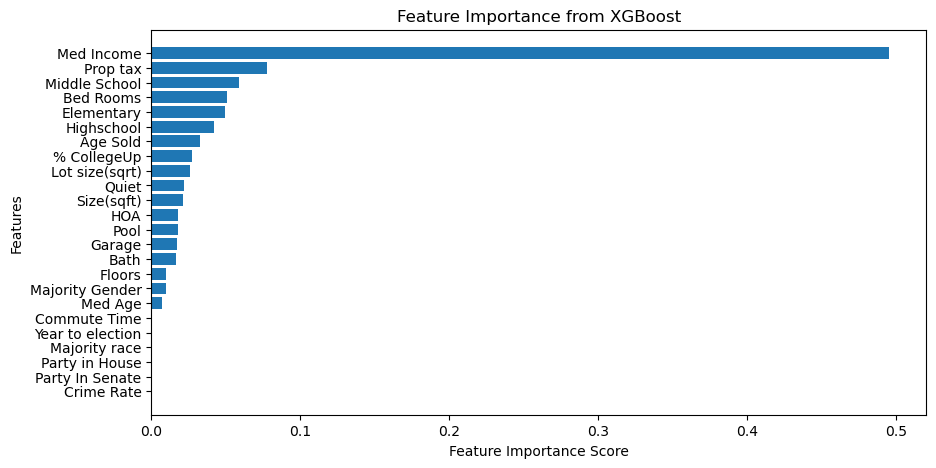

Selected 10 Important Features: ['Age Sold', 'Size(sqft)', 'Lot size(sqrt)', 'Prop tax', 'Med Income', '% CollegeUp', 'Bed Rooms', 'Elementary', 'Middle School', 'Highschool']
Reduced Feature XGBoost R²: 0.5850, MSE: 2010.1083, RMSE: 44.8342
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Tuned XGBoost R²: 0.6036, MSE: 1920.0454, RMSE: 43.8183
Best hyperparameters after feature selection: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}
Ensemble XGBoost + Linear Regression R²: 0.6165, MSE: 1857.3477, RMSE: 43.0970


In [110]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

### STEP 1: Train XGBoost with Default Settings
default_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
default_xgb.fit(X_train, y_train)
y_pred_default = default_xgb.predict(X_test)

r2_default = r2_score(y_test, y_pred_default)
mse_default = mean_squared_error(y_test, y_pred_default)
rmse_default = np.sqrt(mse_default)

print(f"Default XGBoost R²: {r2_default:.4f}, MSE: {mse_default:.4f}, RMSE: {rmse_default:.4f}")

### STEP 2: Train XGBoost with Best Hyperparameters from GridSearchCV
best_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    colsample_bytree=1.0,
    learning_rate=0.01,
    max_depth=6,
    min_child_weight=5,
    n_estimators=200,
    subsample=0.8
)

best_xgb.fit(X_train, y_train)
y_pred_best = best_xgb.predict(X_test)

r2_best = r2_score(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)

print(f"Optimized XGBoost R²: {r2_best:.4f}, MSE: {mse_best:.4f}, RMSE: {rmse_best:.4f}")

### STEP 3: Feature Importance Analysis
feature_importances = best_xgb.feature_importances_
feature_names = X_train.columns
importance_df = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh([x[0] for x in importance_df], [x[1] for x in importance_df])
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance from XGBoost")
plt.gca().invert_yaxis()
plt.show()

### STEP 4: Recursive Feature Elimination (RFE)
# Use XGBoost with RFE to remove redundant features
selector = RFE(best_xgb, n_features_to_select=10, step=1)
selector = selector.fit(X_train, y_train)

important_features = X_train.columns[selector.support_]
X_train_reduced = X_train[important_features]
X_test_reduced = X_test[important_features]

print(f"Selected {len(important_features)} Important Features: {list(important_features)}")

### STEP 5: Retrain XGBoost with Important Features
best_xgb.fit(X_train_reduced, y_train)
y_pred_reduced = best_xgb.predict(X_test_reduced)

r2_reduced = r2_score(y_test, y_pred_reduced)
mse_reduced = mean_squared_error(y_test, y_pred_reduced)
rmse_reduced = np.sqrt(mse_reduced)

print(f"Reduced Feature XGBoost R²: {r2_reduced:.4f}, MSE: {mse_reduced:.4f}, RMSE: {rmse_reduced:.4f}")

### STEP 6: Hyperparameter Fine-Tuning on Reduced Features
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(
    estimator=best_xgb,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search_xgb.fit(X_train_reduced, y_train)
best_xgb_tuned = grid_search_xgb.best_estimator_

y_pred_tuned = best_xgb_tuned.predict(X_test_reduced)
r2_tuned = r2_score(y_test, y_pred_tuned)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mse_tuned)

print(f"Tuned XGBoost R²: {r2_tuned:.4f}, MSE: {mse_tuned:.4f}, RMSE: {rmse_tuned:.4f}")
print("Best hyperparameters after feature selection:", grid_search_xgb.best_params_)

### STEP 7: Ensemble XGBoost with Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_reduced, y_train)
y_pred_lr = lin_reg.predict(X_test_reduced)

r2_lr = r2_score(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

# Blend XGBoost & Linear Regression Predictions
y_pred_ensemble = (y_pred_tuned * 0.7) + (y_pred_lr * 0.3)  # Weighted blending

r2_ensemble = r2_score(y_test, y_pred_ensemble)
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
rmse_ensemble = np.sqrt(mse_ensemble)

print(f"Ensemble XGBoost + Linear Regression R²: {r2_ensemble:.4f}, MSE: {mse_ensemble:.4f}, RMSE: {rmse_ensemble:.4f}")
